In [1]:
import numpy as np
def gen_random_connectome(N):
  """
  Return Gg (NxN), Gs (NxN), is_inhibitory (Nx1)
  """
  Gg = np.random.rand(N,N)
  Gs = np.random.rand(N,N)
  is_inhibitory = (np.random.rand(N) > 0.5) * 1.0
  return (Gg, Gs, is_inhibitory)

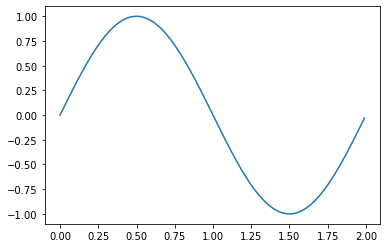

In [2]:
import pylab as plt

dt = 0.01
def get_gold_dynamics(dt):
  """
  Generate 1 period of the golden dynamics
  The return value is already discretized according to dt 
  """
  # Period length in s
  period_s = 2.0
  ts = np.arange(0, period_s, dt)
  return ts, np.sin((2 * np.pi / period_s) * ts)

ts, ys = get_gold_dynamics(dt)
plt.plot(ts, ys)

In [3]:
def ts_distance_euclidean(ts1, ts2):
  return np.linalg.norm(ts1 - ts2)
ts_distance_euclidean(np.array([1] * 5), np.array([0] * 5))

2.23606797749979

In [4]:
def create_obj_fun(N):
  def obj_fun(x):
    gg_vec = x[:N]
    gs_vec = x[N+1:]
    gg_mat = gg_vec.reshape(N,N)
    gs_mat = gs_vec.reshape(N,N)
    
    """
    TODO:
    - Gg should be symmetric
    - PCA
    - get_distance
    - test on scipy optimizers
    """
  return obj_fun

Timestep 0 out of 400
Timestep 100 out of 400
Timestep 200 out of 400
Timestep 300 out of 400
Total runtime = 0.06s


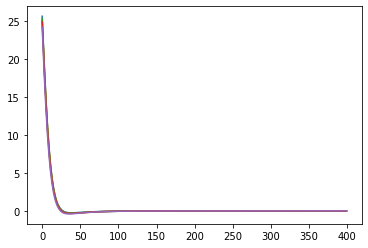

In [7]:
import project_path
from model.neural_model import NeuralModel

N = 5
Gg, Gs, is_inhibitory = gen_random_connectome(N)

model = NeuralModel(
  N = 5,
  Gg = Gg,
  Gs = Gs,
  is_inhibitory = is_inhibitory,
  I_ext = np.array([0] * N))

simul_s = 4.0
simul_ts = int(simul_s / model.dt)
(v_mat, s_mat, v_normalized_mat) = model.run(simul_ts)

plt.plot(v_normalized_mat)
_=_